# **Default Setting**

* Python: 3.6.9
* ML Framework: tf-nightly-gpu 2.5.0-dev20201208
* CPU: AMD Ryzen 5 5600X 6-Core Processor
* GPU: GeForce RTX 3070 (8G) (CUDA 11.1)
* RAM: 32G
* Platform: linux 20.04 LTS

Install below APIs using anaconda as belows.

```
conda create -n py36 python=3.6.9
conda acitvate py36
conda install jupyterlab
pip3 install tensorflow-gpu=2.4.0
pip3 install tensorflow-addons
conda install pandas, matplotlib
```

And now, you can run jupyter lab (or jupyter notebook).

```
jupyter lab
```

In [1]:
%env NOTEBOOKNAME try33
%env LOCAL_DATA_PATH data
%env CHECKPOINT_PATH ckpt
%env SUBMISSION_PATH submission

env: NOTEBOOKNAME=try33
env: LOCAL_DATA_PATH=data
env: CHECKPOINT_PATH=ckpt
env: SUBMISSION_PATH=submission


In [2]:
import tensorflow as tf
import tensorflow_addons as tfa

import datetime
import glob
import os
import platform

import numpy as np
import pandas as pd

from collections import OrderedDict
from matplotlib import pyplot as plt

print(f"tf.__version__: {tf.__version__}")
print(f"tfa.__version__: {tfa.__version__}")

tf.__version__: 2.4.0
tfa.__version__: 0.11.2


/home/myunggyo/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow_addons/utils/ensure_tf_install.py:68: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.2.0 and strictly below 2.4.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.4.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
# !python -V

In [5]:
# !cat /proc/cpuinfo

In [6]:
!nvidia-smi

Tue Dec 22 13:39:04 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 455.32.00    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Graphics Device     On   | 00000000:0A:00.0 Off |                  N/A |
|  0%   32C    P8    23W / 220W |     70MiB /  7979MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
# !df -h

In [8]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:           31Gi       904Mi        24Gi       3.0Mi       6.1Gi        30Gi
Swap:         2.0Gi          0B       2.0Gi


In [9]:
# platform.platform()

In [10]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

# **Define Arguments**

In [11]:
args = OrderedDict({
    # Basic
    "SEED": 42,
    "TEST_SIZE": 0.2,
    "EPOCH": 10,
    "INIT_LR": 1e-3,
    
    # Dataframe
    "NUM_TEST_CSV": 81,
    
    # Dataset Pipeline
    "WINDOW_INP": 7 * 24 * 2, # 336, 7 days
    "WINDOW_TAR": 2 * 24 * 2, # 96, 2 days
    "WINDOW_SHIFT": 1 * 24 * 2, # 1 day
    "WINDOW_STRIDE": 1,
    "WINDOW_DR": True, # Drop remainders
    "AUTO": tf.data.experimental.AUTOTUNE,
    
    "GLOBAL_BATCH_SIZE": 128,
    
    # Model
    "NUM_UNITS": 64, # lstm units
    "NUM_FEATURES": 7, # Day_sin, Day_cos, DHI, DNI, WS, RH, T
    "NUM_QUANTILE": 9, # tau = 0.1 to 0.9
    
})

args

OrderedDict([('SEED', 42),
             ('TEST_SIZE', 0.2),
             ('EPOCH', 10),
             ('INIT_LR', 0.001),
             ('NUM_TEST_CSV', 81),
             ('WINDOW_INP', 336),
             ('WINDOW_TAR', 96),
             ('WINDOW_SHIFT', 48),
             ('WINDOW_STRIDE', 1),
             ('WINDOW_DR', True),
             ('AUTO', -1),
             ('GLOBAL_BATCH_SIZE', 128),
             ('NUM_UNITS', 64),
             ('NUM_FEATURES', 7),
             ('NUM_QUANTILE', 9)])

# **Load Datasets**

## **Train / Validation**

```
"""Using sklearn.model_selection.train_test_split()"""

tr_df, vl_df = train_test_split(
    df, 
    test_size = args["TEST_SIZE"]
    random_state = args["SEED"])
    
```

In [12]:
df = pd.read_csv(os.path.join(os.environ["LOCAL_DATA_PATH"], "train", "train.csv"))

In [13]:
# df.head()

In [14]:
# df.describe()

In [15]:
args["SPLIT_LEN"] = int(df.shape[0] * (1. - args["TEST_SIZE"]))

tr_df = df[:args["SPLIT_LEN"]]
vl_df = df[args["SPLIT_LEN"]:]

tr_df.shape, vl_df.shape

((42048, 9), (10512, 9))

In [16]:
def preprocessing(df, is_training = True, day = 24 * 2): # 24 / 0.5 [h]
    # Drop timestampes.
    try:
        # We cannot use day features, thus there is no day-position in test dataset.
        df = df.drop(["Day"], axis = 1) 
    except:
        pass
    
    
    # Timestamp to sin/cos.
    df["Time"] = 2 * df["Hour"].map(int) + (df["Minute"].map(int) // 30)
    
    day_sin = np.sin(df["Time"] * (2 * np.pi / day))
    day_cos = np.cos(df["Time"] * (2 * np.pi / day))
        
    df.insert(loc = 0, column = "DAY_SIN", value = day_sin)
    df.insert(loc = 1, column = "DAY_COS", value = day_cos)
    
    df = df.drop(["Hour", "Minute", "Time"], axis = 1)
    
    
    # Normalize.
    for column in df.columns:
        df[column] = df[column].astype(np.float32) # no want to cast float64
        if is_training:
            args[f"{column}_MAX"] = df[column].max()
            args[f"{column}_MIN"] = df[column].min()
        
        df[column] = (df[column] - args[f"{column}_MIN"]) / (args[f"{column}_MAX"] - args[f"{column}_MIN"])
        
    return df

In [17]:
tr_df = preprocessing(tr_df)
vl_df = preprocessing(vl_df, is_training = False)

In [27]:
tr_df

,DAY_SIN,DAY_COS,DHI,DNI,WS,RH,T,TARGET
0,0.500000,1.000000,0.0,0.0,0.125000,0.665404,0.129630,0.0
1,0.565263,0.995722,0.0,0.0,0.125000,0.665188,0.129630,0.0
2,0.629410,0.982963,0.0,0.0,0.133333,0.694622,0.129630,0.0
3,0.691342,0.961940,0.0,0.0,0.133333,0.694297,0.129630,0.0
4,0.750000,0.933013,0.0,0.0,0.133333,0.731631,0.129630,0.0
...,...,...,...,...,...,...,...,...
42043,0.195619,0.896677,0.0,0.0,0.158333,0.777405,0.481481,0.0
42044,0.250000,0.933013,0.0,0.0,0.216667,0.859106,0.481481,0.0
42045,0.308658,0.961940,0.0,0.0,0.250000,0.927930,0.462963,0.0
42046,0.370590,0.982963,0.0,0.0,0.283333,0.945460,0.462963,0.0


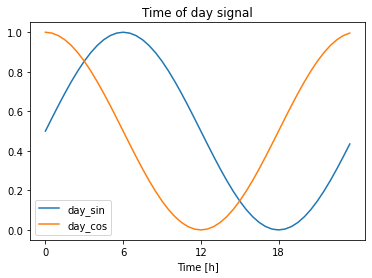

In [28]:
plt.plot(np.array(tr_df["DAY_SIN"])[:48], label = "day_sin")
plt.plot(np.array(tr_df["DAY_COS"])[:48], label = "day_cos")
plt.legend()
plt.xticks(np.arange(0, 48, 12), np.arange(0, 24, 6))
plt.xlabel('Time [h]')
plt.title('Time of day signal')
plt.show()

In [29]:
tr_df.describe()

,DAY_SIN,DAY_COS,DHI,DNI,WS,RH,T,TARGET
count,42048.000000,42048.000000,42048.000000,42048.000000,42048.000000,42048.000000,42048.000000,42048.000000
mean,0.500000,0.500000,0.121944,0.221116,0.207556,0.541524,0.507346,0.177724
std,0.353558,0.353558,0.196495,0.330891,0.121929,0.234951,0.187127,0.257484
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.146447,0.146447,0.000000,0.000000,0.116667,0.362839,0.351852,0.000000
50%,0.500000,0.500000,0.000000,0.000000,0.183333,0.552970,0.481481,0.000000
75%,0.853553,0.853553,0.164773,0.436261,0.266667,0.710962,0.648148,0.319348
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [30]:
vl_df.describe()

,DAY_SIN,DAY_COS,DHI,DNI,WS,RH,T,TARGET
count,10512.000000,10512.000000,10512.000000,10512.000000,10512.000000,10512.000000,10512.000000,10512.000000
mean,0.500000,0.500000,0.121541,0.224094,0.193125,0.496120,0.589129,0.179402
std,0.353570,0.353570,0.197900,0.327441,0.105171,0.249596,0.179646,0.259177
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.011795,0.148148,0.000000
25%,0.146447,0.146447,0.000000,0.000000,0.116667,0.290878,0.444444,0.000000
50%,0.500000,0.500000,0.000000,0.000000,0.175000,0.485553,0.592593,0.000000
75%,0.853553,0.853553,0.166667,0.467422,0.258333,0.675197,0.722222,0.326876
max,1.000000,1.000000,0.990530,0.966006,0.683333,1.000000,1.000000,0.995393


## **Test**

In [18]:
ts_filenames = [os.path.join(os.environ["LOCAL_DATA_PATH"], "test", f"{i}.csv") for i in range(args["NUM_TEST_CSV"])]
ts_dfs = [preprocessing(pd.read_csv(ts_filename), is_training = False) for ts_filename in ts_filenames]
ts_df = pd.concat(ts_dfs)

In [32]:
ts_df.head()

,DAY_SIN,DAY_COS,DHI,DNI,WS,RH,T,TARGET
0,0.500000,1.000000,0.0,0.0,0.225000,0.290337,0.351852,0.0
1,0.565263,0.995722,0.0,0.0,0.225000,0.287631,0.353704,0.0
2,0.629410,0.982963,0.0,0.0,0.225000,0.288280,0.355556,0.0
3,0.691342,0.961940,0.0,0.0,0.225000,0.285683,0.357407,0.0
4,0.750000,0.933013,0.0,0.0,0.233333,0.285467,0.359259,0.0


In [33]:
ts_df.describe()

,DAY_SIN,DAY_COS,DHI,DNI,WS,RH,T,TARGET
count,27216.000000,27216.000000,27216.000000,27216.000000,27216.000000,27216.000000,27216.000000,27216.000000
mean,0.500000,0.500000,0.111880,0.237133,0.189333,0.419916,0.532339,0.182508
std,0.353560,0.353560,0.173494,0.338179,0.105967,0.207518,0.209003,0.261381
min,0.000000,0.000000,0.000000,0.000000,0.008333,-0.029001,0.061111,0.000000
25%,0.146447,0.146447,0.000000,0.000000,0.108333,0.254166,0.359259,0.000000
50%,0.500000,0.500000,0.011364,0.000000,0.166667,0.424629,0.512963,0.005636
75%,0.853553,0.853553,0.157197,0.477809,0.241667,0.576669,0.690741,0.325853
max,1.000000,1.000000,0.960227,1.018886,0.916667,0.919597,1.031482,0.995365


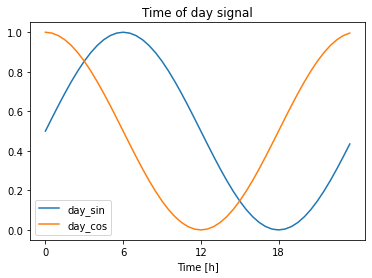

In [34]:
plt.plot(np.array(ts_df["DAY_SIN"])[:48], label = "day_sin")
plt.plot(np.array(ts_df["DAY_COS"])[:48], label = "day_cos")
plt.legend()
plt.xticks(np.arange(0, 48, 12), np.arange(0, 24, 6))
plt.xlabel('Time [h]')
plt.title('Time of day signal')
plt.show()

# **Phase \#1: Target Predict Model**

## **Make Dataset Pipelines**

In [19]:
@tf.function
def _split_window(features):
    """inp: [batch, 7], tar: [batch, 1]"""
    return tf.split(features, [-1, 1], axis = 0)

In [20]:
tr_tensor = tf.constant(tr_df, dtype = tf.float32)
vl_tensor = tf.constant(vl_df, dtype = tf.float32)
ts_tensor = tf.constant(ts_df, dtype = tf.float32)

tr_dataset = tf.data.Dataset.from_tensor_slices(tr_tensor
                    ).map(_split_window, num_parallel_calls = args["AUTO"]
                    ).batch(args["GLOBAL_BATCH_SIZE"]
                    ).cache(
                    ).prefetch(args["AUTO"])

vl_dataset = tf.data.Dataset.from_tensor_slices(vl_tensor
                    ).map(_split_window, num_parallel_calls = args["AUTO"]
                    ).batch(args["GLOBAL_BATCH_SIZE"]
                    ).cache(
                    ).prefetch(args["AUTO"])

ts_dataset = tf.data.Dataset.from_tensor_slices(ts_tensor
                    ).map(_split_window, num_parallel_calls = args["AUTO"]
                    ).batch(args["GLOBAL_BATCH_SIZE"]
#                     ).cache(
                    ).prefetch(args["AUTO"])

# Print the shapes
print(f"tr_dataset: {tr_dataset.element_spec}")
print(f"vl_dataset: {vl_dataset.element_spec}")
print(f"ts_dataset: {ts_dataset.element_spec}")

tr_dataset: (TensorSpec(shape=(None, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))
vl_dataset: (TensorSpec(shape=(None, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))
ts_dataset: (TensorSpec(shape=(None, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))


### **Take Samples**

In [28]:
for element in tr_dataset.take(1):
    foo, bar = element
    print(foo.shape, bar.shape)

(128, 7) (128, 1)


In [29]:
for element in vl_dataset.take(1):
    foo, bar = element
    print(foo.shape, bar.shape)

(128, 7) (128, 1)


In [30]:
for element in ts_dataset.take(1):
    foo, bar = element
    print(foo.shape, bar.shape)

(128, 7) (128, 1)


## **Create Network**

```
"""Pytorch Style"""
class TARGET_MODEL(tf.keras.Model):
    def __init__(self, model_name, units = 64):
        super(TARGET_MODEL, self).__init__(name = model_name)
        self.units = units
        
        self.dense1 = tf.keras.layers.Dense(units = self.units, activation = "relu")
        self.dense2 = tf.keras.layers.Dense(units = self.units, activation = "relu")
        self.dense3 = tf.keras.layers.Dense(units = 1)
        
    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.dense3(x)
        
        return x            
```

In [21]:
def TARGET_MODEL(model_name, units = 64):
    model_input = tf.keras.layers.Input(shape = [7, ], dtype = tf.float32)
    x = tf.keras.layers.Dense(units = units, activation = "relu")(model_input)
    x = tf.keras.layers.Dense(units = units, activation = "relu")(x)
    model_output = tf.keras.layers.Dense(1)(x)
    
    return tf.keras.Model(
        inputs = model_input,
        outputs = model_output,
        name = model_name)

In [22]:
tmp = TARGET_MODEL("tmp")
tmp.summary()

Model: "tmp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 7)]               0         
_________________________________________________________________
dense (Dense)                (None, 64)                512       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [109]:
# tf.keras.utils.plot_model(tmp)

In [39]:
del tmp

## **Compile and Fit**

Dacon defines the loss as shown below.

$$ L_\tau = maximum(\zeta\tau, \zeta(\tau-1)) $$

However, [the pinball loss of tensorflow-addons](https://www.tensorflow.org/addons/api_docs/python/tfa/losses/pinball_loss) is implemented as follows.

$$ L_\tau = \begin{cases} \zeta\tau & \text{ if } \zeta \geq 0 \\ -\zeta(1-\tau)=\zeta(\tau-1) & \text{ if } \zeta < 0 \end{cases}$$

The description of the symbols used in is as follows.

* $\zeta$ : y_true - y_pred
* $\tau$ : Quantile values in \[0.1, 0.2, ..., 0.9\]
* $L_\tau$ : Pinball loss function with $\tau$

The two formulas seem intuitively different, but if you actually divide the interval, you can see that they are the same. However, in experience, it seems to force an underforecast when the evaluation expression of dacon is $\tau=0.1, 0.2$. In fact, for $\tau=0.1, 0.2$, the prediction (blue lines) in the target models mostly overlaps the label (yellow lines) or lies below the graph.

In [23]:
# Define customized pinball loss function, named tuned_pinball_loss thus there exists finely differences 
# between the function of tensorflow-addons and the requirements of DACON.

# Ref: https://github.com/tensorflow/addons/blob/v0.11.2/tensorflow_addons/losses/quantiles.py

@tf.function
def tuned_pinball_loss(
    y_true: tf.Tensor, 
    y_pred: tf.Tensor, 
    tau: float = 0.5,
) -> tf.Tensor:
    """Computes the pinball loss between "y_true" and "y_pred" like dacon-style."""
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)
    tau = tf.cast(tau, y_pred.dtype)
    
    delta_y = tf.math.abs(y_true - y_pred)
    # tau = tau if y_true >= y_pred else (1 - tau) (must be elemental-wised)
    _tau = tf.where(tf.math.greater_equal(y_true, y_pred), tau, 1 - tau)
    
    pinball = delta_y * _tau
    return tf.reduce_mean(pinball, axis = -1)


class TunedPinballLoss(tfa.utils.keras_utils.LossFunctionWrapper):
    def __init__(
        self,
        tau: tfa.utils.types.FloatTensorLike = 0.5,
        reduction: str = tf.keras.losses.Reduction.AUTO,
        name: str = "tuned_pinball_loss",
    ):
        super().__init__(tuned_pinball_loss, reduction = reduction, name = name, tau = tau)

In [24]:
%%time

histories = []

for tau in np.arange(0.1, 1, 0.1):    
    target_model = TARGET_MODEL(
        model_name = f"T{tau:.1f}",
        units = 64)

    target_model.compile(
        loss = TunedPinballLoss(tau = tau),
        optimizer = tf.keras.optimizers.Adam(args["INIT_LR"]))
    
    # Checkpoint callback.
    ckpt_path = os.path.join(
        os.environ["CHECKPOINT_PATH"], os.environ["NOTEBOOKNAME"], target_model.name, "cp-{epoch:03d}-{val_loss:.4f}.ckpt")
    ckpt_dir = os.path.dirname(ckpt_path)
    os.makedirs(ckpt_dir, exist_ok = True)
    
    cp_callback = tf.keras.callbacks.ModelCheckpoint(
        ckpt_path, verbose = 0, monitor = "val_loss", save_weights_only = True, save_best_only = True)
    
    # TensorBoard callback.
    log_dir = os.path.join(
        "logs", "fit", os.environ["NOTEBOOKNAME"], 
        datetime.datetime.now().strftime(f"{target_model.name}-%Y%m%d-%H%M%S"))
    tb_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq = 1)

    print(f"Target Model {target_model.name}...")

    history = target_model.fit(
        tr_dataset,
        validation_data = vl_dataset,
        epochs = 500,
        verbose = 0,
        callbacks = [cp_callback, tb_callback])

    histories.append(history)
    
    del target_model

Target Model T0.1...
Target Model T0.2...
Target Model T0.3...
Target Model T0.4...
Target Model T0.5...
Target Model T0.6...
Target Model T0.7...
Target Model T0.8...
Target Model T0.9...
CPU times: user 45min 6s, sys: 2min 50s, total: 47min 57s
Wall time: 28min 54s


## **Predict**

In [25]:
def load_latest_taret_models(notebookname = os.environ["NOTEBOOKNAME"]):
    """Load latest weights of target model from saved ckeckpoints."""
    ckpt_folders = sorted(glob.glob(os.path.join(os.environ["CHECKPOINT_PATH"], notebookname, "T*")))
    target_models = []

    for f in ckpt_folders:
        latest = tf.train.latest_checkpoint(f)
        print(f"Load latest checkpoints: {latest}...")

        # Define a new target model and load checkpoints.
        target_model = TARGET_MODEL(model_name = latest.split(os.path.sep)[2])
        ckpt = tf.train.Checkpoint(target_model)
        ckpt.restore(latest).expect_partial()

        target_models.append(target_model)
        
    return target_models

In [26]:
target_models = load_latest_taret_models()

# Sample evaluation.
target_models[0].compile(
    loss = tfa.losses.PinballLoss(tau = 0.1),
    optimizer = tf.keras.optimizers.Adam(args["INIT_LR"]))
target_models[0].evaluate(ts_dataset, verbose = 1)

Load latest checkpoints: ckpt/try33/T0.1/cp-494-0.0033.ckpt...
Load latest checkpoints: ckpt/try33/T0.2/cp-472-0.0053.ckpt...
Load latest checkpoints: ckpt/try33/T0.3/cp-495-0.0059.ckpt...
Load latest checkpoints: ckpt/try33/T0.4/cp-494-0.0071.ckpt...
Load latest checkpoints: ckpt/try33/T0.5/cp-491-0.0069.ckpt...
Load latest checkpoints: ckpt/try33/T0.6/cp-492-0.0078.ckpt...
Load latest checkpoints: ckpt/try33/T0.7/cp-483-0.0081.ckpt...
Load latest checkpoints: ckpt/try33/T0.8/cp-453-0.0051.ckpt...
Load latest checkpoints: ckpt/try33/T0.9/cp-495-0.0028.ckpt...
213/213 [==============================] - 0s 731us/step - loss: 0.0028


0.0028867630753666162

## **Visualize**

Visualize between label and predictions.

In [29]:
def draw_history(history, title):
    
    plt.figure(figsize = (7, 3), facecolor = "white", dpi = 80)
    
    plt.plot(history.epoch, history.history["loss"], label = "loss")
    plt.plot(history.epoch, history.history["val_loss"], label = "val_loss")
    
    plt.legend()
    plt.title(title, fontsize = "x-large")
    plt.xlabel("Epoch")
    plt.ylabel("Pinball Loss")
    
    plt.grid(True)
    plt.tight_layout()
    plt.show()

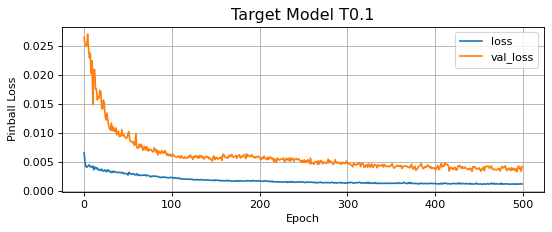

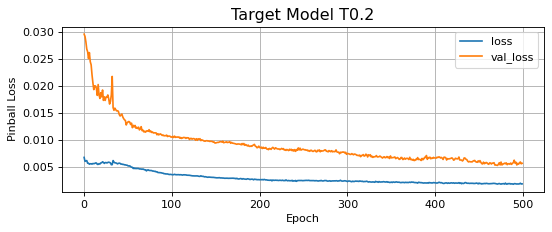

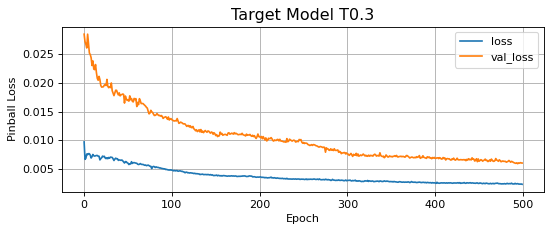

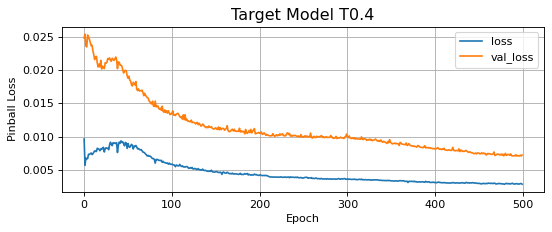

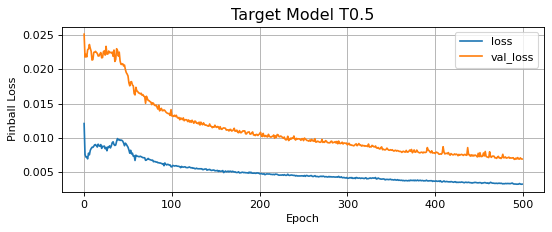

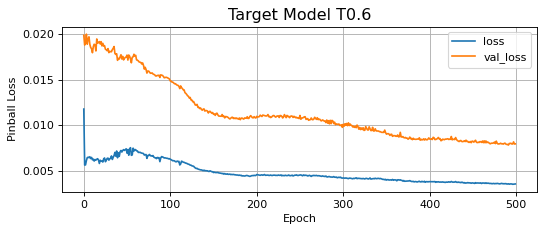

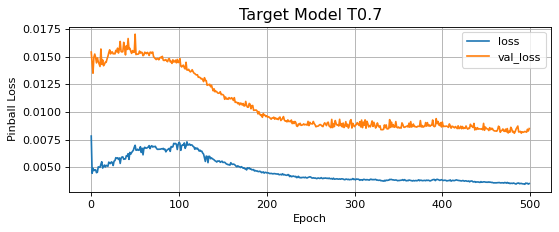

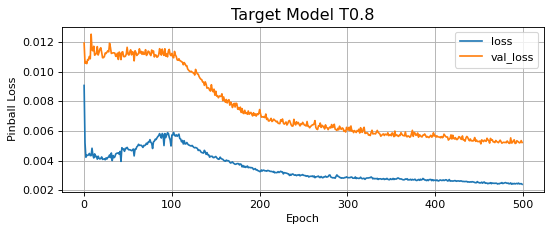

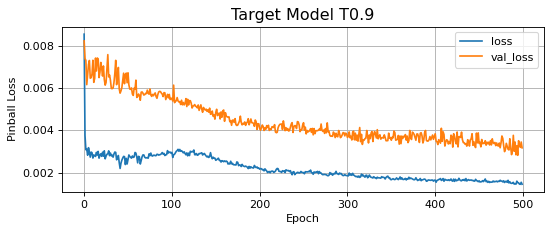

In [30]:
for tau, history in zip(np.arange(0.1, 1, 0.1), histories):
    draw_history(history, title = f"Target Model T{tau:.1f}")

In [ ]:
# %tensorboard --logdir logs/fit --host jupyter-server --port=6006

In [31]:
def draw_pred(y_pred, y_true, model_name, save_fig = True):
    """Draw the predictions and labels."""
    plt.figure(figsize = (14, 4), facecolor = "white")
    plt.plot(y_pred, lw = 1.5, label = "Predictions")
    plt.plot(y_true, lw = 1.5, label = "Label")
    
    plt.title(f"Target Model {model_name}")
    plt.xlabel("Time [day]")
    plt.ylabel("Target [kW]")
    plt.ylim([-0.05, max(y_true) * 1.1])
    plt.legend()
    
    plt.xticks(np.arange(0, args["WINDOW_INP"] + 1, 24 * 2), [f"D+{i}" for i in np.arange(8)])
    plt.grid(True)
    plt.tight_layout()
    
    if save_fig:
        plt.savefig(f"./pngs/{os.environ['NOTEBOOKNAME']}_target-model-{model_name}.png", dpi = 300)
        
    plt.show()

Load latest checkpoints: ckpt/try33/T0.1/cp-494-0.0033.ckpt...
Load latest checkpoints: ckpt/try33/T0.2/cp-472-0.0053.ckpt...
Load latest checkpoints: ckpt/try33/T0.3/cp-495-0.0059.ckpt...
Load latest checkpoints: ckpt/try33/T0.4/cp-494-0.0071.ckpt...
Load latest checkpoints: ckpt/try33/T0.5/cp-491-0.0069.ckpt...
Load latest checkpoints: ckpt/try33/T0.6/cp-492-0.0078.ckpt...
Load latest checkpoints: ckpt/try33/T0.7/cp-483-0.0081.ckpt...
Load latest checkpoints: ckpt/try33/T0.8/cp-453-0.0051.ckpt...
Load latest checkpoints: ckpt/try33/T0.9/cp-495-0.0028.ckpt...


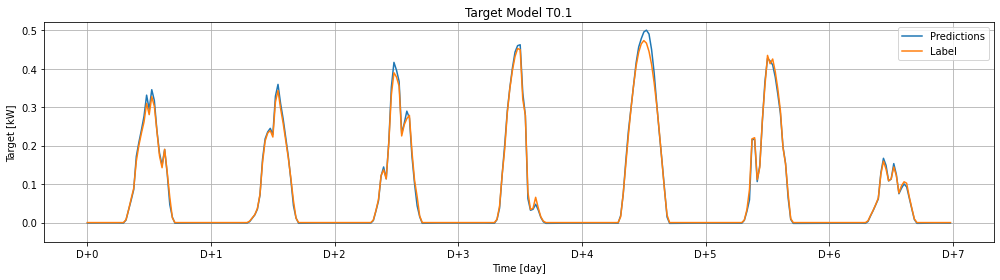

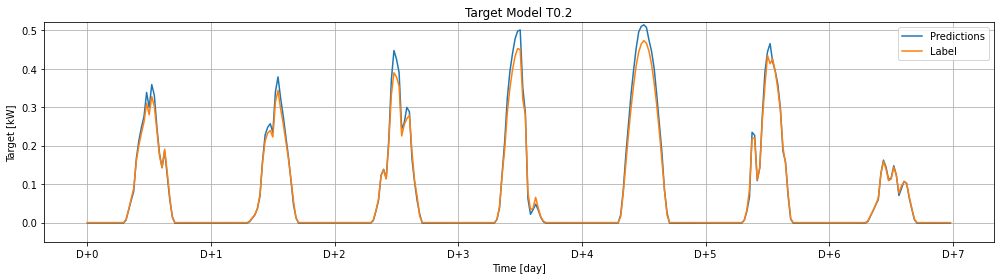

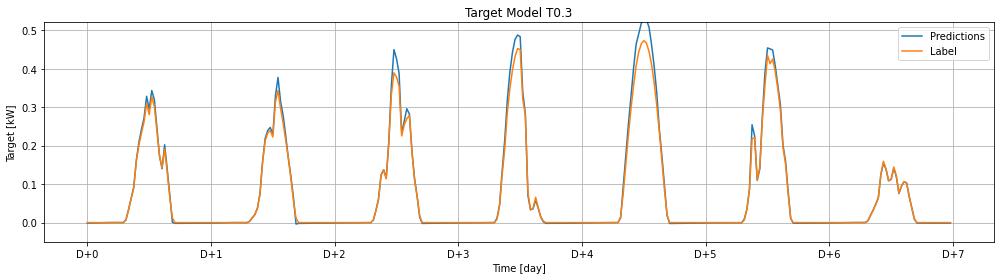

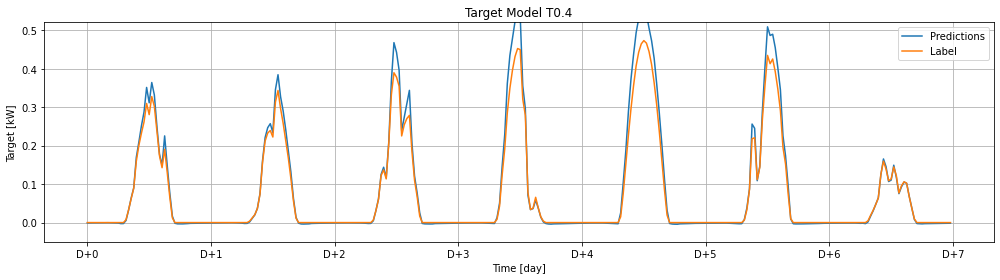

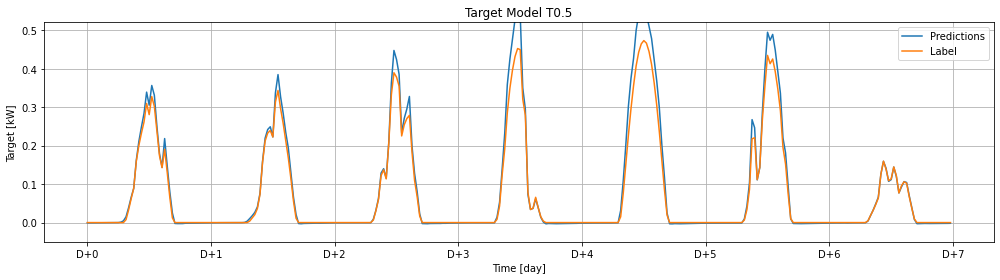

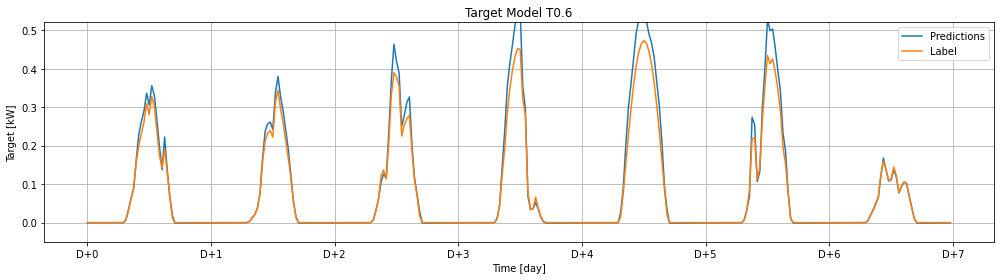

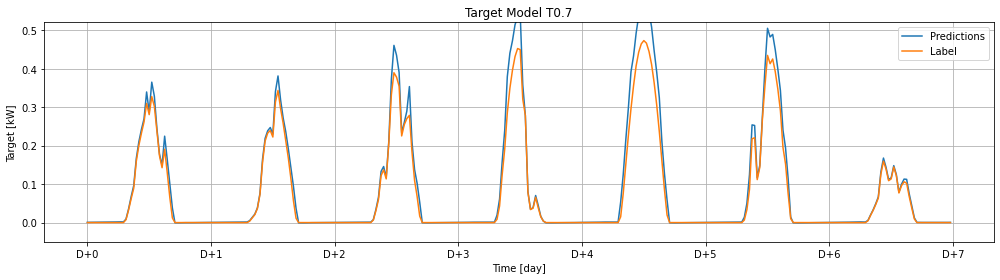

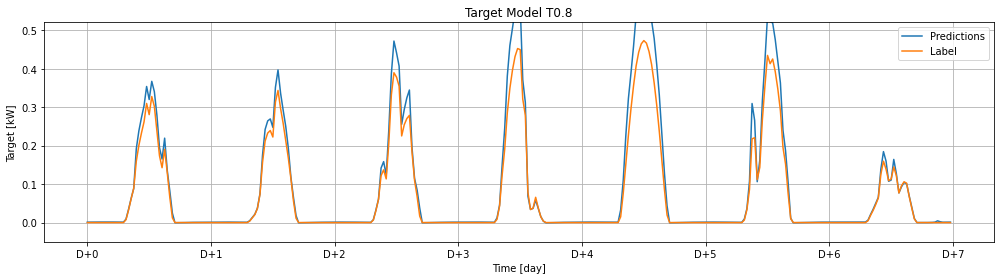

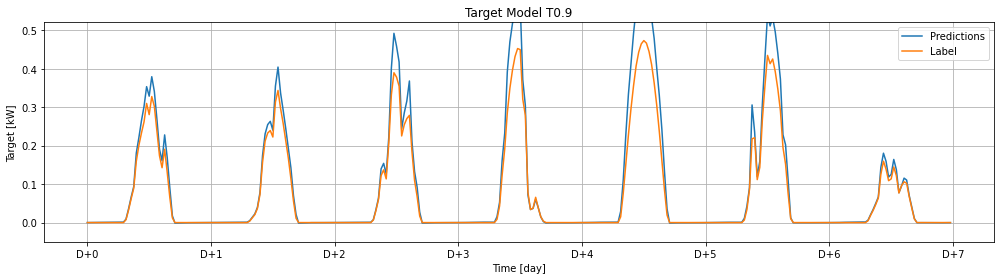

In [32]:
ts_dataset = ts_dataset.unbatch().batch(args["WINDOW_INP"])
target_models = load_latest_taret_models()

for t in ts_dataset.take(1):
    x, y = t # inp, tar
    
    for target_model in target_models:
        draw_pred(y_pred = target_model.predict(x), y_true = y, model_name = target_model.name)

# **Phase \#2: Autoregressive Model**

## **Make Dataset Pipelines**

In [33]:
@tf.function
def _flat_fn_tr(x):
    return x.batch(args["WINDOW_INP"] + args["WINDOW_TAR"])


@tf.function
def _flat_fn_ts(x):
    return x.batch(args["WINDOW_INP"])


@tf.function
def _split_window_tr(features):
    """inp: [batch, 336, 7], tar: (aux: [batch, 96, 7], real: [batch, 96, 1])"""
    inp, tar = tf.split(features, [args["WINDOW_INP"], args["WINDOW_TAR"]], axis = 0)
    return inp[..., :-1], (tar[..., :-1], tar[..., -1:])


@tf.function
def _split_window_ts(features):
    """inp: [batch, 336, 7]"""
    return features[..., :-1]

In [34]:
del tr_dataset, vl_dataset, ts_dataset

tr_dataset = tf.data.Dataset.from_tensor_slices(tr_tensor
                    ).window(args["WINDOW_INP"] + args["WINDOW_TAR"], args["WINDOW_SHIFT"], args["WINDOW_STRIDE"], args["WINDOW_DR"]).flat_map(_flat_fn_tr
                    ).map(_split_window_tr, num_parallel_calls = args["AUTO"]
                    ).batch(args["GLOBAL_BATCH_SIZE"]
                    ).cache(
                    ).prefetch(args["AUTO"])

vl_dataset = tf.data.Dataset.from_tensor_slices(vl_tensor
                    ).window(args["WINDOW_INP"] + args["WINDOW_TAR"], args["WINDOW_SHIFT"], args["WINDOW_STRIDE"], args["WINDOW_DR"]).flat_map(_flat_fn_tr
                    ).map(_split_window_tr, num_parallel_calls = args["AUTO"]
                    ).batch(args["GLOBAL_BATCH_SIZE"]
                    ).cache(
                    ).prefetch(args["AUTO"])

ts_dataset = tf.data.Dataset.from_tensor_slices(ts_tensor
                    ).window(args["WINDOW_INP"], args["WINDOW_INP"], args["WINDOW_STRIDE"], args["WINDOW_DR"]).flat_map(_flat_fn_ts
                    ).map(_split_window_ts, num_parallel_calls = args["AUTO"]
                    ).batch(args["NUM_TEST_CSV"] # not args["GLOBAL_BATCH_SIZE"]
#                     ).cache(
                    ).prefetch(args["AUTO"])

# Print the shapes
print(f"tr_dataset: {tr_dataset.element_spec}")
print(f"vl_dataset: {vl_dataset.element_spec}")
print(f"ts_dataset: {ts_dataset.element_spec}")

tr_dataset: (TensorSpec(shape=(None, 336, 7), dtype=tf.float32, name=None), (TensorSpec(shape=(None, 96, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 96, 1), dtype=tf.float32, name=None)))
vl_dataset: (TensorSpec(shape=(None, 336, 7), dtype=tf.float32, name=None), (TensorSpec(shape=(None, 96, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 96, 1), dtype=tf.float32, name=None)))
ts_dataset: TensorSpec(shape=(None, None, 7), dtype=tf.float32, name=None)


### **Take Samples**

In [49]:
for element in tr_dataset.take(1):
    foo, (bar, qux) = element
    print(foo.shape, bar.shape, qux.shape)

(128, 336, 7) (128, 96, 7) (128, 96, 1)


In [50]:
for element in vl_dataset.take(1):
    foo, (bar, qux) = element
    print(foo.shape, bar.shape, qux.shape)

(128, 336, 7) (128, 96, 7) (128, 96, 1)


In [51]:
for element in ts_dataset.take(1):
    foo = element
    print(foo.shape)

(81, 336, 7)


## **Create Network**

In [35]:
class AR_LSTM(tf.keras.Model):
    def __init__(self, target_model, units, out_steps, name):
        super(AR_LSTM, self).__init__(name = name)
        self.target_model = target_model # [batch, 7] => [batch, 1]
        self.units = units
        self.out_steps = out_steps
        self.num_features = args["NUM_FEATURES"]
        
        self.lstm_rnn = tf.keras.layers.RNN([
            tf.keras.layers.LSTMCell(self.units),
            tf.keras.layers.LSTMCell(self.units),
            tf.keras.layers.LSTMCell(self.units)], return_state = True)
        self.dense = tf.keras.layers.Dense(self.num_features)
        
    
    def warmup(self, inputs):
        # [batch, time, features] => [batch, units]
        x, *state = self.lstm_rnn(inputs)
        # [batch, units] => [batch, num_features]
        prediction = self.dense(x)
        return prediction, state
        
        
    def call(self, inputs, training = None):
        aux_outputs, real_outputs = [], []
        
        prediction, state = self.warmup(inputs)
        
        aux_outputs.append(prediction)
        real_outputs.append(self.target_model(prediction))
        
        for n in range(1, self.out_steps):
            x = tf.expand_dims(prediction, axis = 1)
            # [batch, num_features] => [batch, units]
            x, *state = self.lstm_rnn(x, initial_state = state, training = training)
            # [batch, units] => [batch, num_features]
            prediction = self.dense(x)
            
            aux_outputs.append(prediction)
            real_outputs.append(self.target_model(prediction))
            
        aux_outputs = tf.stack(aux_outputs, axis = 1)
        real_outputs = tf.stack(real_outputs, axis = 1)
        return (aux_outputs, real_outputs)

## **Compile and Fit**

In [36]:
%%time

target_models = load_latest_taret_models()
target_models.reverse() # to use pop()

for tau in np.arange(0.1, 1, 0.1):
    target_model = target_models.pop()
    # target_model.trainable = False # fix the weights
    
    model = AR_LSTM(
        target_model = target_model,
        units = args["NUM_UNITS"],
        out_steps = args["WINDOW_TAR"],
        name = f"P{tau:.1f}")

    model.compile(
        loss = TunedPinballLoss(tau = tau),
        # Loss weights are not [0.8, 0.2] (sum=1), thus the loss_weight of real_output need to be 1.
        # Also, In order to deliberately lower the amount of change in the target_model weight 
        # and focus more on the AR_LSTM model, the loss for the auxiliary output was specifically set high.
        loss_weights = [1.0, 0.2], 
        optimizer = tf.keras.optimizers.Adam(args["INIT_LR"]))
    
    # Checkpoint callback.
    ckpt_path = os.path.join(
        os.environ["CHECKPOINT_PATH"], os.environ["NOTEBOOKNAME"], model.name, "cp-{epoch:03d}-{val_loss:.4f}.ckpt")
    ckpt_dir = os.path.dirname(ckpt_path)
    os.makedirs(ckpt_dir, exist_ok = True)
    
    cp_callback = tf.keras.callbacks.ModelCheckpoint(
        ckpt_path, verbose = 0, monitor = "val_loss", save_weights_only = True, save_best_only = True)
    
    # TensorBoard callback to visualize loss & val_loss.
    log_dir = os.path.join(
        "logs", "fit", os.environ["NOTEBOOKNAME"], 
        datetime.datetime.now().strftime(f"{model.name}-%Y%m%d-%H%M%S"))
    tb_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq = 1)

    print(f"\nModel {model.name}...\n")
    
    _ = model.fit(
        tr_dataset,
        validation_data = vl_dataset,
        epochs = args["EPOCH"],
        verbose = 2,
        callbacks = [cp_callback, tb_callback])
    
    del target_model, model # for save memories

Load latest checkpoints: ckpt/try33/T0.1/cp-494-0.0033.ckpt...
Load latest checkpoints: ckpt/try33/T0.2/cp-472-0.0053.ckpt...
Load latest checkpoints: ckpt/try33/T0.3/cp-495-0.0059.ckpt...
Load latest checkpoints: ckpt/try33/T0.4/cp-494-0.0071.ckpt...
Load latest checkpoints: ckpt/try33/T0.5/cp-491-0.0069.ckpt...
Load latest checkpoints: ckpt/try33/T0.6/cp-492-0.0078.ckpt...
Load latest checkpoints: ckpt/try33/T0.7/cp-483-0.0081.ckpt...
Load latest checkpoints: ckpt/try33/T0.8/cp-453-0.0051.ckpt...
Load latest checkpoints: ckpt/try33/T0.9/cp-495-0.0028.ckpt...

Model P0.1...

Epoch 1/10
7/7 - 151s - loss: 0.0393 - output_1_loss: 0.0356 - output_2_loss: 0.0188 - val_loss: 0.0380 - val_output_1_loss: 0.0335 - val_output_2_loss: 0.0225
Epoch 2/10
7/7 - 5s - loss: 0.0361 - output_1_loss: 0.0323 - output_2_loss: 0.0190 - val_loss: 0.0358 - val_output_1_loss: 0.0321 - val_output_2_loss: 0.0183
Epoch 3/10
7/7 - 5s - loss: 0.0350 - output_1_loss: 0.0313 - output_2_loss: 0.0188 - val_loss: 0.03

In [ ]:
# models[0].summary()

In [35]:
# %tensorboard --logdir logs/fit --host jupyter-server --port=6006

## **Predict**

In [37]:
def load_latest_models():
    """Load latest weights of target model from saved ckeckpoints."""
    ckpt_folders = sorted(glob.glob(os.path.join(os.environ["CHECKPOINT_PATH"], os.environ["NOTEBOOKNAME"], "P*")))
    models = []

    for f in ckpt_folders:
        latest = tf.train.latest_checkpoint(f)
        print(f"Load latest checkpoints: {latest}...")

        # Define a new target model and load checkpoints.
        model_name = latest.split(os.path.sep)[2]
        model = AR_LSTM(
            target_model = TARGET_MODEL(model_name = f"T{model_name[1:]}"),
            units = args["NUM_UNITS"],
            out_steps = args["WINDOW_TAR"],
            name = model_name)

        ckpt = tf.train.Checkpoint(model)
        ckpt.restore(latest).expect_partial()

        models.append(model)
        
    return models

In [38]:
%%time
models = load_latest_models()
preds = [np.array(model.predict(ts_dataset)[-1])[..., 0] for model in models] # use only real outputs.

Load latest checkpoints: ckpt/try33/P0.1/cp-010-0.0261.ckpt...
Load latest checkpoints: ckpt/try33/P0.2/cp-009-0.0426.ckpt...
Load latest checkpoints: ckpt/try33/P0.3/cp-010-0.0664.ckpt...
Load latest checkpoints: ckpt/try33/P0.4/cp-010-0.0612.ckpt...
Load latest checkpoints: ckpt/try33/P0.5/cp-010-0.0585.ckpt...
Load latest checkpoints: ckpt/try33/P0.6/cp-010-0.0859.ckpt...
Load latest checkpoints: ckpt/try33/P0.7/cp-010-0.0677.ckpt...
Load latest checkpoints: ckpt/try33/P0.8/cp-010-0.0922.ckpt...
Load latest checkpoints: ckpt/try33/P0.9/cp-010-0.0563.ckpt...
CPU times: user 2min 43s, sys: 58.5 ms, total: 2min 43s
Wall time: 2min 42s


In [39]:
submission = pd.read_csv(os.path.join(os.environ["LOCAL_DATA_PATH"], "sample_submission.csv"), index_col = "id")
submission.head()

,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
id,,,,,,,,,
0.csv_Day7_0h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.csv_Day7_0h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.csv_Day7_1h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.csv_Day7_1h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.csv_Day7_2h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
for column, pred in zip(submission.columns, preds):
    foo = np.reshape(pred, (-1,))
    foo = foo * (args["TARGET_MAX"] - args["TARGET_MIN"]) + args["TARGET_MIN"]
#     foo = np.where(foo < 0, 0, foo) # clip by value
    
    submission[column] = foo

In [51]:
submission.head()

,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
id,,,,,,,,,
0.csv_Day7_0h00m,-3.436398,-2.413761,-0.481411,1.063471,-0.099085,3.592667,6.963912,29.327023,59.434368
0.csv_Day7_0h30m,-3.421806,-2.420014,-0.508294,1.135992,-0.181423,3.602175,6.898243,29.577150,59.645763
0.csv_Day7_1h00m,-3.373431,-2.406168,-0.462289,1.260322,-0.334073,3.760437,7.044063,30.072680,59.929260
0.csv_Day7_1h30m,-3.304714,-2.374575,-0.328702,1.379613,-0.503940,4.084461,7.343351,30.679756,60.248016
0.csv_Day7_2h00m,-3.202505,-2.315504,-0.120155,1.552776,-0.672575,4.598163,8.189104,31.434759,60.609879


In [52]:
submission.to_csv(
    os.path.join(os.environ["SUBMISSION_PATH"], f"{os.environ['NOTEBOOKNAME']}_submission.csv"))